This notebook details the process of running various classification models on the employee burnout dataset, from the data cleaning, to model tuning and drawing conclusions.

### Data Cleaning

In [1]:
import pandas as pd
import numpy as np

In [2]:
np.random.seed(100)

In [3]:
data = pd.read_csv("employee-data/train.csv")

In [4]:
data_test = pd.read_csv("employee-data/test.csv")

In [5]:
data.shape

(22750, 9)

In [6]:
data.columns

Index(['Employee ID', 'Date of Joining', 'Gender', 'Company Type',
       'WFH Setup Available', 'Designation', 'Resource Allocation',
       'Mental Fatigue Score', 'Burn Rate'],
      dtype='object')

In [7]:
data_test.shape

(12250, 8)

In [8]:
data_test.columns

Index(['Employee ID', 'Date of Joining', 'Gender', 'Company Type',
       'WFH Setup Available', 'Designation', 'Resource Allocation',
       'Mental Fatigue Score'],
      dtype='object')

It appears that the test data does not contain a burn rate for each employee. In order to evaluate the performance of our model, we will work from only the labeled data (ie the training data).

Some general information about the each feature:

- Employee ID: The unique ID allocated for each employee (example: fffe390032003000)
- Date of Joining: The date-time when the employee has joined the organization (example: 2008-12-30)
- Gender: The gender of the employee (Male/Female)
- Company Type: The type of company where the employee is working (Service/Product)
- WFH Setup Available: Is the work from home facility available for the employee (Yes/No)
- Designation: The designation of the employee of work in the organization. In the range of [0.0, 5.0] bigger is higher designation.
- Resource Allocation: The amount of resource allocated to the employee to work, ie. number of working hours. In the range of [1.0, 10.0] (higher means more resource)
- Mental Fatigue Score: The level of fatigue mentally the employee is facing. In the range of [0.0, 10.0] where 0.0 means no fatigue and 10.0 means completely fatigue.
- Burn Rate: The value we need to predict for each employee telling the rate of Burnout while working. In the range of [0.0, 1.0] where the higher the value is more is the burn out.

In [9]:
df = data

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22750 entries, 0 to 22749
Data columns (total 9 columns):
Employee ID             22750 non-null object
Date of Joining         22750 non-null object
Gender                  22750 non-null object
Company Type            22750 non-null object
WFH Setup Available     22750 non-null object
Designation             22750 non-null float64
Resource Allocation     21369 non-null float64
Mental Fatigue Score    20633 non-null float64
Burn Rate               21626 non-null float64
dtypes: float64(4), object(5)
memory usage: 1.6+ MB


In [11]:
df.describe()

,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
count,22750.000000,21369.000000,20633.000000,21626.000000
mean,2.178725,4.481398,5.728188,0.452005
std,1.135145,2.047211,1.920839,0.198226
min,0.000000,1.000000,0.000000,0.000000
25%,1.000000,3.000000,4.600000,0.310000
50%,2.000000,4.000000,5.900000,0.450000
75%,3.000000,6.000000,7.100000,0.590000
max,5.000000,10.000000,10.000000,1.000000


We will first transform some of the data to make it more manageable to work with.

In [12]:
from datetime import datetime

In [13]:
df.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52


In [14]:
today = datetime.today()

In [15]:
sec_yr = 365 * 24 * 60 * 60

In [16]:
df["Date of Joining"] = df["Date of Joining"].map(lambda date: datetime.strptime(date, "%Y-%m-%d"))

In [17]:
df["Years at Company"] = df["Date of Joining"].map(lambda date: round(((today - date).total_seconds()/sec_yr), 2))

In [18]:
df.drop(columns = ["Date of Joining", "Employee ID"], inplace=True)

In [19]:
cols = ['Years at Company','Gender', 'Company Type', 'WFH Setup Available', 'Designation',
       'Resource Allocation', 'Mental Fatigue Score', 'Burn Rate']
df = df[cols]

In [20]:
df.rename(columns={"Burn Rate": "Burnout Level"}, inplace=True)

In [21]:
df.duplicated().sum()

38

In [22]:
df.drop_duplicates(inplace=True)

Since our model will apply classification algorithms, we will convert the burn rate columns into discrete classes of 1-5, with 1 being the lowest and 5 being the highest in terms of burnout.

In [23]:
df["Burnout Level"] = df["Burnout Level"].map(lambda rate: 5 if (rate > 0.8 and rate <= 1) else rate)

In [24]:
df["Burnout Level"] = df["Burnout Level"].map(lambda rate: 4 if (rate > 0.6 and rate <= 0.8) else rate)

In [25]:
df["Burnout Level"] = df["Burnout Level"].map(lambda rate: 3 if (rate > 0.4 and rate <= 0.6) else rate)

In [26]:
df["Burnout Level"] = df["Burnout Level"].map(lambda rate: 2 if (rate > 0.2 and rate <= 0.4) else rate)

In [27]:
df["Burnout Level"] = df["Burnout Level"].map(lambda rate: 1 if rate <= 0.2 else rate)

In [28]:
df["Burnout Level"].value_counts(normalize=True)

3.0    0.369847
2.0    0.296943
4.0    0.183557
1.0    0.110838
5.0    0.038814
Name: Burnout Level, dtype: float64

In [29]:
df.isna().sum()

Years at Company           0
Gender                     0
Company Type               0
WFH Setup Available        0
Designation                0
Resource Allocation     1380
Mental Fatigue Score    2109
Burnout Level           1122
dtype: int64

It appears that there are missing values for the predictors Resource Allocation and Mental Fatigue Score, and for the target class Burnout Level. First, we will drop the nan values from Burnout level. Dropping the missing data from the two predictor categories would result in a loss of class 1 (burnout between 0 and 0.2) entirely, so we will impute the median for now.

In [30]:
df.dropna(subset = ["Burnout Level"], inplace=True)

In [31]:
df.isna().sum().sum()

3216

In [32]:
df.shape

(21590, 8)

In [33]:
df_pre = df.copy()

In [34]:
ra_med = df["Resource Allocation"].median()
mf_med = df["Mental Fatigue Score"].median()

In [35]:
df_pre["Resource Allocation"].fillna(value=ra_med, inplace=True)

In [36]:
df_pre["Mental Fatigue Score"].fillna(value=mf_med, inplace=True)

In [37]:
df_pre.isna().sum()

Years at Company        0
Gender                  0
Company Type            0
WFH Setup Available     0
Designation             0
Resource Allocation     0
Mental Fatigue Score    0
Burnout Level           0
dtype: int64

In [38]:
df.isna().sum()

Years at Company           0
Gender                     0
Company Type               0
WFH Setup Available        0
Designation                0
Resource Allocation     1277
Mental Fatigue Score    1939
Burnout Level              0
dtype: int64

In [39]:
df_pre.head()

,Years at Company,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burnout Level
0,12.26,Female,Service,No,2.0,3.0,3.8,1.0
1,12.09,Male,Service,Yes,1.0,2.0,5.0,2.0
2,12.82,Female,Product,Yes,2.0,4.0,5.8,3.0
3,12.16,Male,Service,Yes,1.0,1.0,2.6,1.0
4,12.44,Female,Service,No,3.0,7.0,6.9,3.0


### Exploratory Data Analysis

Now that we have done some initial data cleaning, we can begin the process of EDA

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context("notebook")
sns.set_palette("Spectral")
fs = (10, 10)
fss = (5, 5)
fs_long = (10, 15)
fs_wide = ((15, 10))

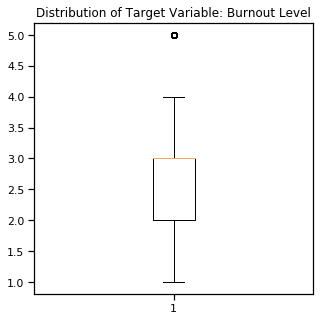

In [41]:
plt.figure(figsize=fss)
plt.boxplot(df_pre["Burnout Level"], showfliers=True)
plt.title("Distribution of Target Variable: Burnout Level")
plt.show()

<Figure size 360x360 with 0 Axes>

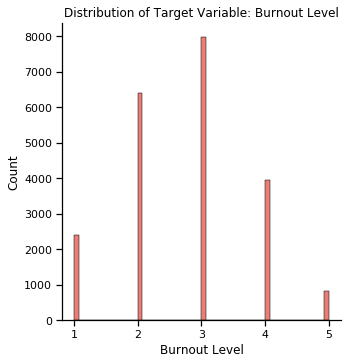

In [42]:
plt.figure(figsize=fss)
sns.displot(df_pre["Burnout Level"], kde=False)
plt.title("Distribution of Target Variable: Burnout Level")
plt.show()

Target variable is fairly normally distributed, with most instances falling into the burnout category of 3, and less in the two extremes of 1 and 5.

In [43]:
df_num = df_pre[["Years at Company", "Designation", "Resource Allocation", "Mental Fatigue Score"]]

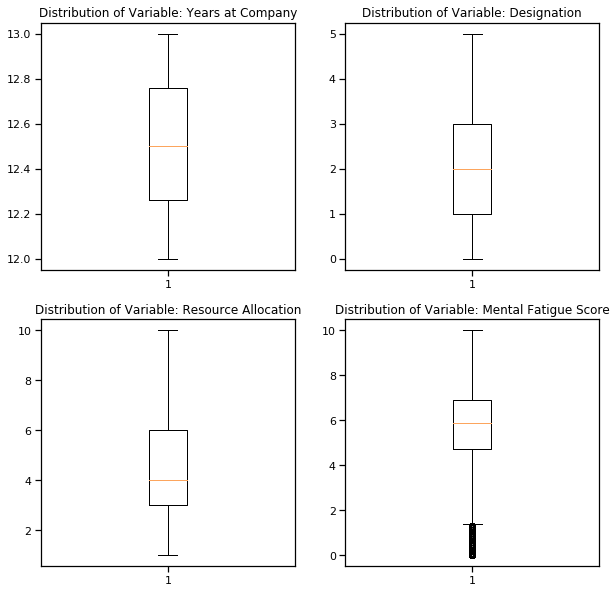

In [44]:
fig, axs = plt.subplots(2,2, figsize=(fs))
axs = axs.ravel()

for i in range(4):

    axs[i].boxplot(df_num.iloc[:, i], showfliers=True)
    axs[i].set_title("Distribution of Variable: " + str(df_num.iloc[:, i].name))

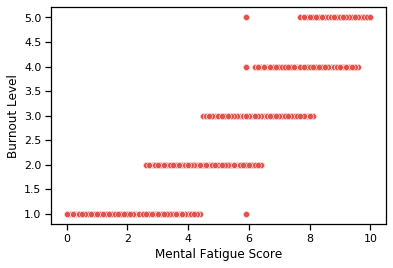

In [45]:
sns.scatterplot(x=df_pre["Mental Fatigue Score"], y=df_pre["Burnout Level"])
plt.show()

Mental fatigue score appears to be positively correlated with Burnout Level (ie as mental fatigue increases, burnout also tends to increase).

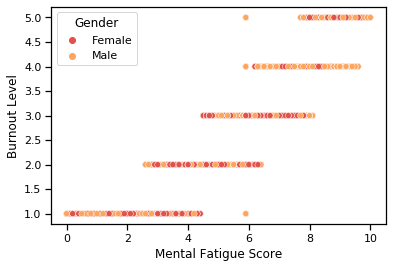

In [46]:
sns.scatterplot(x=df_pre["Mental Fatigue Score"], y=df_pre["Burnout Level"], hue=df_pre["Gender"])
plt.show()

In [47]:
df_pre["Gender"].value_counts(normalize=True)

Female    0.524502
Male      0.475498
Name: Gender, dtype: float64

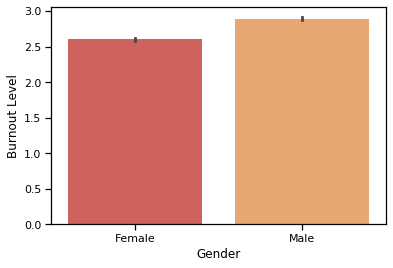

In [48]:
sns.barplot(x=df_pre["Gender"], y=df_pre["Burnout Level"])
plt.show()

It appears that men had slightly higher burnout levels on average.

In [49]:
df_pre.groupby(["Gender"]).median()

,Years at Company,Designation,Resource Allocation,Mental Fatigue Score,Burnout Level
Gender,,,,,
Female,12.5,2.0,4.0,5.8,3.0
Male,12.5,2.0,5.0,6.0,3.0


However, the medians both appear to converge at 3 for both males and females.

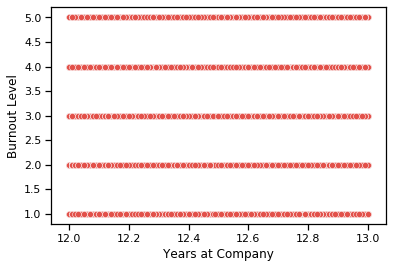

In [50]:
sns.scatterplot(x=df_pre["Years at Company"], y=df_pre["Burnout Level"])
plt.show()

There doesn't appear to be much of an influence from years at the company on burnout level, although this may be due to the fact that there is not much variation in terms of years worked.

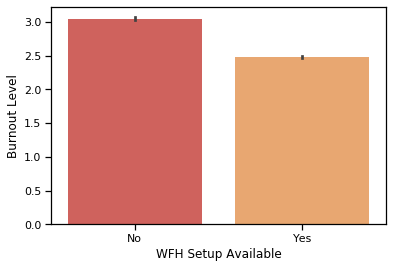

In [51]:
sns.barplot(x=df_pre["WFH Setup Available"], y=df_pre["Burnout Level"])
plt.show()

Not having a work from home setup appeared to correlate to higher burnout levels on average.

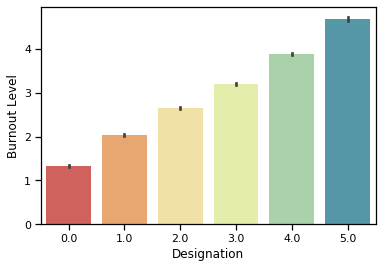

In [52]:
sns.barplot(x=df_pre["Designation"], y=df_pre["Burnout Level"])
plt.show()

Higher designations (Higher positions) appeared to also correlate positively to higher burnout levels.

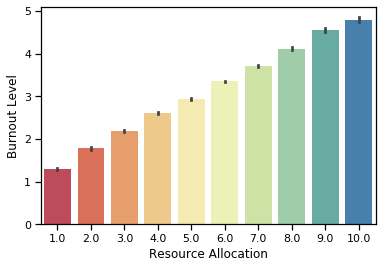

In [53]:
sns.barplot(x=df_pre["Resource Allocation"], y=df_pre["Burnout Level"], palette = "Spectral")
plt.show()

Higher resource allocation (ie more working hours) appears to also correlate positively with higher burnout. 

After doing some initial investigation, it appears employee burnout is greater in males, those who hold higher positions, and those who are allocated more working hours. It also seems that employees without a functioning WFH setup have a higher burnout level on average.

In [54]:
df_pre.groupby(["Burnout Level"]).median()

,Years at Company,Designation,Resource Allocation,Mental Fatigue Score
Burnout Level,,,,
1.0,12.50,1.0,2.0,2.5
2.0,12.50,2.0,3.0,4.7
3.0,12.50,2.0,5.0,6.2
4.0,12.51,3.0,6.0,7.7
5.0,12.51,4.0,8.0,9.1


In [55]:
high_burn = df_pre.loc[(df_pre["Burnout Level"] == 4) | (df_pre["Burnout Level"] == 5)]

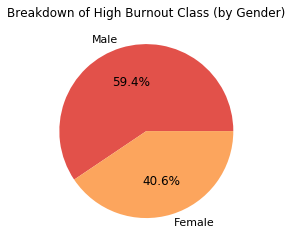

In [56]:
sizes = high_burn["Gender"].value_counts(normalize=True)
labels = sizes.index
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title("Breakdown of High Burnout Class (by Gender)")
plt.show()

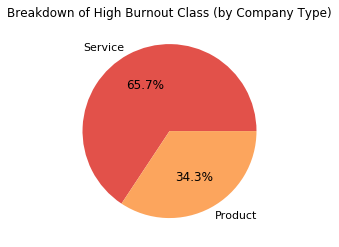

In [57]:
sizes = high_burn["Company Type"].value_counts(normalize=True)
labels = sizes.index
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title("Breakdown of High Burnout Class (by Company Type)")
plt.show()

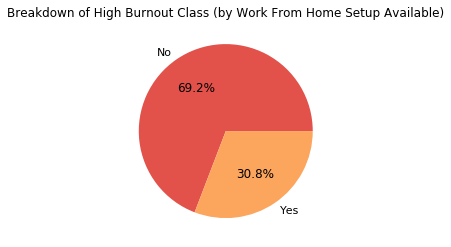

In [58]:
sizes = high_burn["WFH Setup Available"].value_counts(normalize=True)
labels = sizes.index
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title("Breakdown of High Burnout Class (by Work From Home Setup Available)")
plt.show()

Of the highest burnout classes (level 4 and 5), 60% were male, 66% worked in a service oriented company, and 70% did not have a WFH setup available.

In [59]:
df_cat = df_pre[["Gender", "Company Type", "WFH Setup Available", "Designation", "Resource Allocation", "Burnout Level"]]

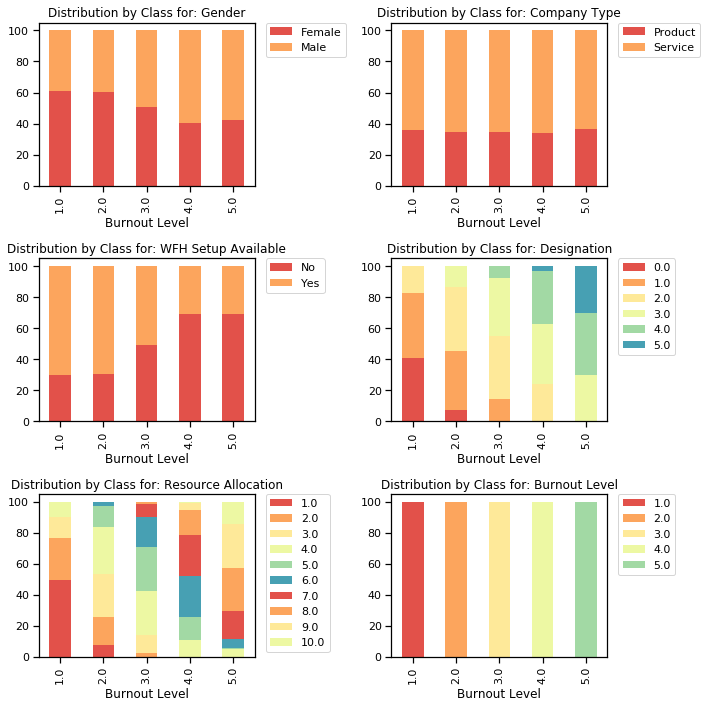

In [60]:
fig, axs = plt.subplots(3,2, figsize=fs)
axs = axs.ravel()

for i, ax in enumerate(axs):
    
    grp_obj = df_cat.groupby("Burnout Level")[df_cat.iloc[:, i].name].value_counts(normalize=True).mul(100)
    grp_obj.unstack().plot.bar(stacked=True, ax=ax)
    ax.set_title("Distribution by Class for: " + str(df_cat.iloc[:, i].name))
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()


Here we can further see how the distributions of our predictors change between classes

### Modeling

We will now apply various classification algorithms to the cleaned dataset. The target is to classify employees in one of the 5 burnout levels based on the other predictor variables. We will first run multiple "vanilla" models to get a baseline. Some of the algorithms we will apply are:

- Logistic Regression
- K Nearest Neighbors (KNN)
- Bayes Classification
- Decision Trees
- Ensemble Methods (Random Forest, Adaboost, Gradient Boosted Trees, XGBoost)
- SVM

#### Data Preparation

We will begin by creating dummy variables for our categorical variables so the data can be read by the various algorithms. We will also create a random state for reproducibility.

In [61]:
rand = 1

In [62]:
y = df["Burnout Level"]
X = df.drop(columns = "Burnout Level", axis = 1)

In [63]:
X.head()

,Years at Company,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score
0,12.26,Female,Service,No,2.0,3.0,3.8
1,12.09,Male,Service,Yes,1.0,2.0,5.0
2,12.82,Female,Product,Yes,2.0,NaN,5.8
3,12.16,Male,Service,Yes,1.0,1.0,2.6
4,12.44,Female,Service,No,3.0,7.0,6.9


In [64]:
X = pd.get_dummies(X, columns = ["Gender", "Company Type", "WFH Setup Available"])

Now that all the data is in numeric form, we can impute values using the KNN imputer for the two predictors with nan values (instead of using the median).

In [65]:
from sklearn.impute import KNNImputer

In [66]:
imputer = KNNImputer(n_neighbors=5)
X = pd.DataFrame(imputer.fit_transform(X),columns = X.columns)

We will now split our data into training and testing data, so we can measure the accuracy of our model on "new" data.

In [67]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = rand)

#### Metrics and Functions

In [68]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import plot_confusion_matrix

In [69]:
cmap = "plasma"

In [70]:
def return_metrics(actual, preds):
    df = pd.DataFrame(classification_report(actual, preds, output_dict=True)).transpose().apply(lambda x: round(x, 2))
    return df

In [71]:
def fit_return_metrics(model, X_train, y_train, X_test, y_test):
    modelf = model.fit(X_train, y_train)
    train_preds = modelf.predict(X_train)
    test_preds = modelf.predict(X_test)
    df_tr = pd.DataFrame(classification_report(y_train, train_preds, output_dict=True)).transpose().apply(lambda x: round(x, 2))
    df_ts = pd.DataFrame(classification_report(y_test, test_preds, output_dict=True)).transpose().apply(lambda x: round(x, 2))
    print("Training Metrics: \n" + str(df_tr) + "\n")
    print("Test Metrics: \n" + str(df_ts))
    return df_tr, df_ts

In [72]:
def return_conf_matrix(model, X_train, y_train, X_test, y_test):
    fig, (ax1, ax2) = plt.subplots(2, figsize=(fs_wide))
    conf_tr = plot_confusion_matrix(model, X_train, y_train, ax = ax1, cmap=cmap)
    ax1.set_title("Training Matrix")
    conf_ts = plot_confusion_matrix(model, X_test, y_test, ax = ax2, cmap=cmap)
    ax2.set_title("Test Matrix")
    plt.tight_layout()
    plt.show()

In [73]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(fss))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

In [74]:
def preprocess(data):
    datac = data.copy()
    datac["Date of Joining"] = datac["Date of Joining"].map(lambda date: datetime.strptime(date, "%Y-%m-%d"))
    datac["Years at Company"] = datac["Date of Joining"].map(lambda date: round(((today - date).total_seconds()/sec_yr), 2))
    data_p = datac.drop(columns = ["Employee ID", "Date of Joining"], axis=1)
    cols = ['Years at Company','Gender', 'Company Type', 'WFH Setup Available', 'Designation',
       'Resource Allocation', 'Mental Fatigue Score']
    data_p = data_p[cols]
    data_pre = pd.get_dummies(data_p, columns = ["Gender", "Company Type", "WFH Setup Available"])
    ids = data["Employee ID"]
    return data_pre, ids

In [75]:
def predict(model, data, ids):
    datac = data.copy()
    fatigue_scores = pd.DataFrame(ids, columns=["Employee ID"])
    fatigue_scores["Burnout Level (Preds)"] = model.predict(datac)
    return fatigue_scores

#### Baseline Models

##### Logistic Regression

Logistic regression uses S shaped logistic function to transform inputs into an output between 0 and 1, representing the probability of belonging to a class. 

In [76]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [77]:
scaled_pipeline_log = Pipeline([("ss", StandardScaler()),
                             ("lr", LogisticRegression(random_state=rand))])

In [78]:
lg_tr1, lg_ts1 = fit_return_metrics(scaled_pipeline_log, X_train, y_train, X_test, y_test)

Training Metrics: 
              precision  recall  f1-score   support
1.0                0.84    0.74      0.79   1749.00
2.0                0.75    0.76      0.76   4860.00
3.0                0.73    0.77      0.75   6006.00
4.0                0.71    0.70      0.70   2964.00
5.0                0.78    0.60      0.68    613.00
accuracy           0.74    0.74      0.74      0.74
macro avg          0.76    0.71      0.73  16192.00
weighted avg       0.74    0.74      0.74  16192.00

Test Metrics: 
              precision  recall  f1-score  support
1.0                0.87    0.79      0.83   644.00
2.0                0.75    0.78      0.76  1551.00
3.0                0.72    0.76      0.74  1979.00
4.0                0.69    0.66      0.67   999.00
5.0                0.75    0.60      0.67   225.00
accuracy           0.74    0.74      0.74     0.74
macro avg          0.76    0.72      0.74  5398.00
weighted avg       0.74    0.74      0.74  5398.00


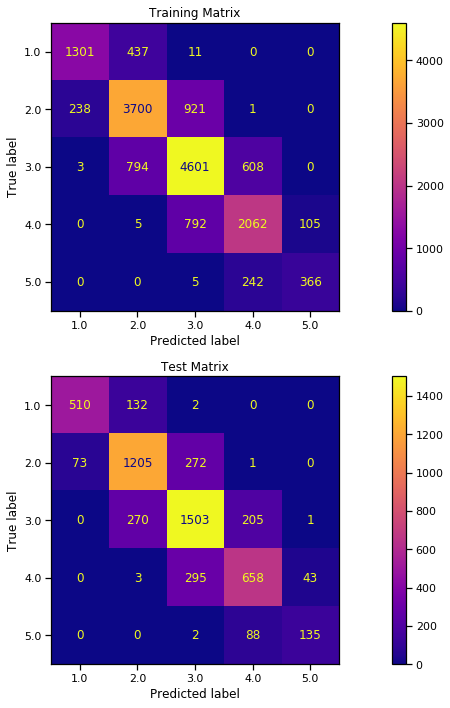

In [79]:
return_conf_matrix(scaled_pipeline_log, X_train, y_train, X_test, y_test)

Vanilla logistic regression model has fair accuracy (approx 74% of all predictions were correctly classified for level of burnout). Precision overall scored similar (On average, out of all the times the model predicted that the person would have a burnout level of X, 74% actually had that level of burnout). Recall also had a score of 74% (On average, out of all the actual instances with a burnout level of X, our model predicted that burnout level 74% of the time). Precision and recall is fairly balanced in this first case (not skewed towards False Positives or False Negatives), as evidenced by the F1 score of 74%.

However, when we look at the metrics for each class, we see that the model has trouble discerning between the higher burnout levels. For example, level 5 (high burnout) had a recall of 60% (meaning that out of all the people who actually scored a 5, our model only predicted 5, 60% of the time). This could mean that our model is not discerning enough between the higher classes, and is currently tuned to minimize instances of False Positives for level 5 (FP = Saying someone has level 5 burnout when in reality they do not) more than it should be - so the model is not conservative enough. This could be an issue of class imbalance, since level 5 burnout only accounts for 3% of the dataset. 

##### KNN

KNN assumes that the smaller distance between points, the more similar they are. Therefore, a point with certain features and in a certain class, should have the same class as a point with similar features. All the point features are simply stored (as a map of "coordinates") in the training step, and then during testing distances between testing and training coordinates are calculated to determine which class the testing point is in (based on the classes of the nearest points).

In [80]:
from sklearn.neighbors import KNeighborsClassifier

In [81]:
scaled_pipeline_knn = Pipeline([("ss", StandardScaler()),
                             ("knn", KNeighborsClassifier())])

In [82]:
kn_tr1, kn_ts1 = fit_return_metrics(scaled_pipeline_knn, X_train, y_train, X_test, y_test)

Training Metrics: 
              precision  recall  f1-score   support
1.0                0.88    0.79      0.83   1749.00
2.0                0.79    0.81      0.80   4860.00
3.0                0.77    0.82      0.80   6006.00
4.0                0.76    0.73      0.75   2964.00
5.0                0.84    0.58      0.69    613.00
accuracy           0.79    0.79      0.79      0.79
macro avg          0.81    0.75      0.77  16192.00
weighted avg       0.79    0.79      0.79  16192.00

Test Metrics: 
              precision  recall  f1-score  support
1.0                0.85    0.74      0.79   644.00
2.0                0.71    0.75      0.73  1551.00
3.0                0.69    0.73      0.71  1979.00
4.0                0.65    0.62      0.63   999.00
5.0                0.76    0.49      0.60   225.00
accuracy           0.71    0.71      0.71     0.71
macro avg          0.73    0.67      0.69  5398.00
weighted avg       0.71    0.71      0.71  5398.00


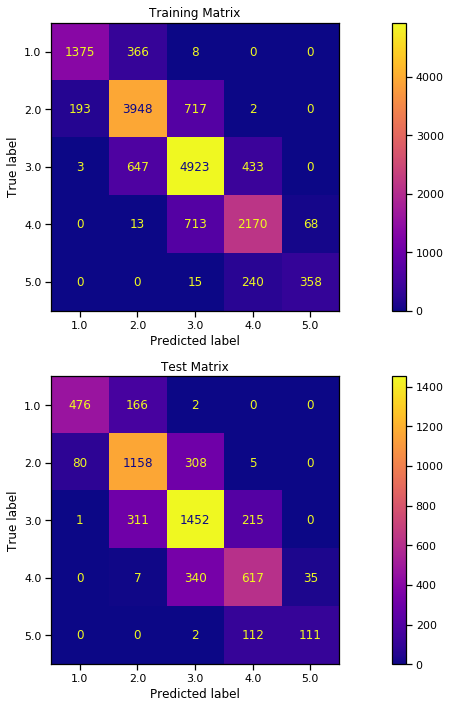

In [83]:
return_conf_matrix(scaled_pipeline_knn, X_train, y_train, X_test, y_test)

This vanilla KNN model appears to perform slightly better than the logistic regression algorithm, but only on the training set. This could signify that the current parameters of the KNN model overfit the model to the training set.

##### Bayes Classification

Bayes Classification assumes that given the predictors are independent, one can estimate the overall probability of being in one class versus another by multiplying the conditional probabilities of the predictors together. The class with the highest probability becomes the class predicted.

In [84]:
from sklearn.naive_bayes import GaussianNB

In [85]:
scaled_pipeline_bay = Pipeline([("ss", StandardScaler()),
                             ("bay", GaussianNB())])

In [86]:
by_tr1, by_ts1 = fit_return_metrics(scaled_pipeline_bay, X_train, y_train, X_test, y_test)

Training Metrics: 
              precision  recall  f1-score  support
1.0                0.74    0.79      0.76   1749.0
2.0                0.71    0.72      0.72   4860.0
3.0                0.72    0.67      0.69   6006.0
4.0                0.64    0.68      0.66   2964.0
5.0                0.62    0.69      0.65    613.0
accuracy           0.70    0.70      0.70      0.7
macro avg          0.69    0.71      0.70  16192.0
weighted avg       0.70    0.70      0.70  16192.0

Test Metrics: 
              precision  recall  f1-score  support
1.0                0.78    0.83      0.80    644.0
2.0                0.70    0.72      0.71   1551.0
3.0                0.72    0.66      0.69   1979.0
4.0                0.65    0.68      0.66    999.0
5.0                0.66    0.73      0.69    225.0
accuracy           0.70    0.70      0.70      0.7
macro avg          0.70    0.72      0.71   5398.0
weighted avg       0.70    0.70      0.70   5398.0


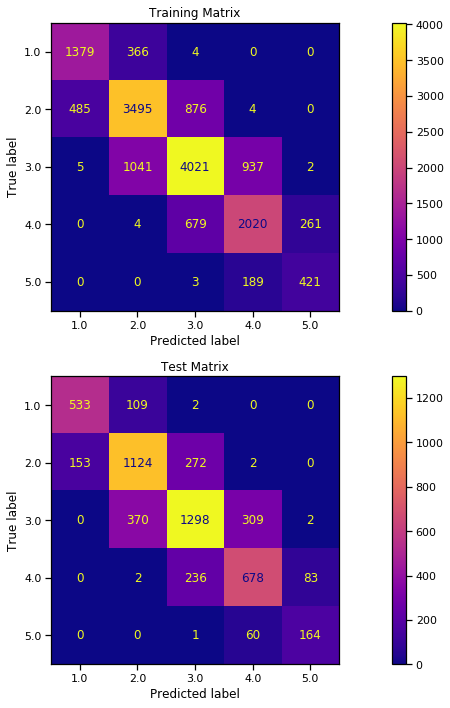

In [87]:
return_conf_matrix(scaled_pipeline_bay, X_train, y_train, X_test, y_test)

The model performed similarly on the training and testing data (overall accuracy of 70%), and had a fair recall score across the different classes (with class 1 being the highest at 83%).

##### Decision Trees

Decision trees are their own classifier and make up the base structure for many ensemble methods. Trees have nodes that partition the sample space into two or more subspaces (branches). Each node considers a different predictor. The training set is used to construct the tree from the top down, maximizing information gain at each node (using entropy or the gini index). Then each test point is run through the trained tree, where it ends at a leaf node that classifies it.

In [88]:
from sklearn.tree import DecisionTreeClassifier

In [89]:
scaled_pipeline_dtr = Pipeline([("ss", StandardScaler()),
                             ("dt", DecisionTreeClassifier(random_state=rand))])

In [90]:
dt_tr1, dt_ts1 = fit_return_metrics(scaled_pipeline_dtr, X_train, y_train, X_test, y_test)

Training Metrics: 
              precision  recall  f1-score   support
1.0                0.99    1.00      1.00   1749.00
2.0                0.99    1.00      0.99   4860.00
3.0                0.99    0.99      0.99   6006.00
4.0                1.00    0.99      0.99   2964.00
5.0                1.00    0.99      0.99    613.00
accuracy           0.99    0.99      0.99      0.99
macro avg          0.99    0.99      0.99  16192.00
weighted avg       0.99    0.99      0.99  16192.00

Test Metrics: 
              precision  recall  f1-score  support
1.0                0.78    0.77      0.77   644.00
2.0                0.67    0.69      0.68  1551.00
3.0                0.66    0.65      0.65  1979.00
4.0                0.59    0.58      0.58   999.00
5.0                0.56    0.57      0.57   225.00
accuracy           0.66    0.66      0.66     0.66
macro avg          0.65    0.65      0.65  5398.00
weighted avg       0.66    0.66      0.66  5398.00


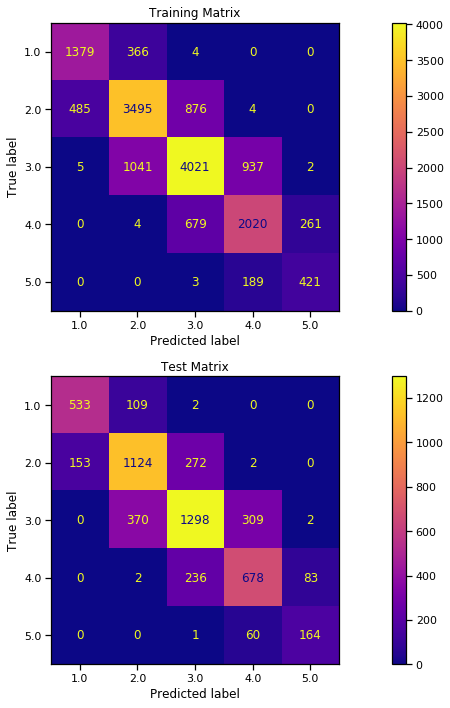

In [91]:
return_conf_matrix(scaled_pipeline_bay, X_train, y_train, X_test, y_test)

The decision tree classifier performed very well on the training data (almost perfect accuracy) but has clearly overfit to the data, as evidenced by the much poorer performance on the testing data (66% overall accuracy).

##### Random Forest

Random forests is a tree based ensemble method that performs both classification and regression tasks. The algorithm makes a "forest" of decision trees by bagging (sampling different parts of the data with replacement) and subspace sampling (random subsample of predictors). Each tree in the forest then "votes" on the class of the test point, and majority decides the class.

In [92]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

In [93]:
scaled_pipeline_rf = Pipeline([("ss", StandardScaler()),
                             ("rf", RandomForestClassifier(random_state=rand))])

In [94]:
rf_tr1, rf_ts1 = fit_return_metrics(scaled_pipeline_rf, X_train, y_train, X_test, y_test)

Training Metrics: 
              precision  recall  f1-score   support
1.0                1.00    1.00      1.00   1749.00
2.0                0.99    0.99      0.99   4860.00
3.0                0.99    0.99      0.99   6006.00
4.0                0.99    0.99      0.99   2964.00
5.0                1.00    0.99      0.99    613.00
accuracy           0.99    0.99      0.99      0.99
macro avg          0.99    0.99      0.99  16192.00
weighted avg       0.99    0.99      0.99  16192.00

Test Metrics: 
              precision  recall  f1-score  support
1.0                0.84    0.79      0.82   644.00
2.0                0.71    0.73      0.72  1551.00
3.0                0.69    0.72      0.70  1979.00
4.0                0.67    0.63      0.65   999.00
5.0                0.72    0.62      0.67   225.00
accuracy           0.71    0.71      0.71     0.71
macro avg          0.73    0.70      0.71  5398.00
weighted avg       0.71    0.71      0.71  5398.00


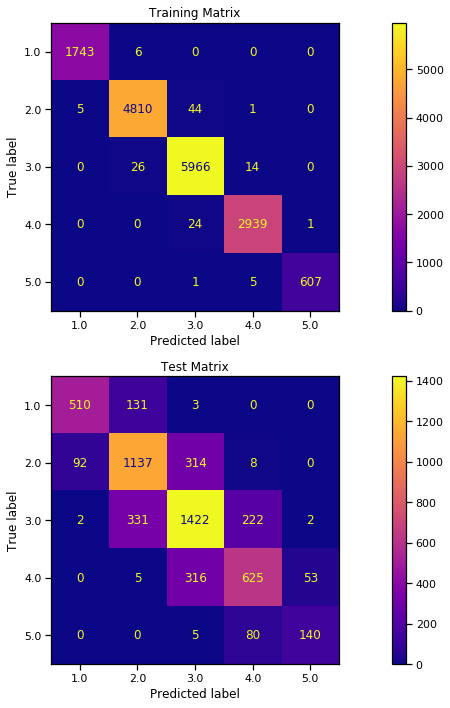

In [95]:
return_conf_matrix(scaled_pipeline_rf, X_train, y_train, X_test, y_test)

Similarly to the decision tree algorithm, a base random forest classifier overfits to the training data but is not generalizable to new data.

##### Gradient Boosted Trees

Boosting algorithms usually use trees as the base structure. They work as follows:

- Train a single weak learner
- Figure out which examples the weak learner got wrong
- Build another weak learner that focuses on the areas the first weak learner got wrong
- Continue this process until a predetermined stopping condition is met, such as until a set number of weak learners have been created, or the model's performance has plateaued

The first gradient boosted algorithm is the gradient boosted tree classifier. The algorithm uses a tree as a base structure. It works by training a single weak learner (tree), then identifying the samples the weak learner got wrong. The algorithm calculates the residuals for each point to determine the overall loss function for the model, and uses gradient descent to train the next weak learner in a way that works to minimize the loss function (by focusing on the harder samples the model got wrong). This is an iterative process that continues until a predetermined stopping condition is met or until the model’s performance plateaus

In [96]:
from sklearn.ensemble import GradientBoostingClassifier

In [97]:
scaled_pipeline_gbt = Pipeline([("ss", StandardScaler()),
                             ("gb", GradientBoostingClassifier(random_state=rand))])

In [98]:
gbt_tr1, gbt_ts1 = fit_return_metrics(scaled_pipeline_gbt, X_train, y_train, X_test, y_test)

Training Metrics: 
              precision  recall  f1-score   support
1.0                0.87    0.76      0.81   1749.00
2.0                0.77    0.77      0.77   4860.00
3.0                0.73    0.80      0.76   6006.00
4.0                0.74    0.70      0.72   2964.00
5.0                0.83    0.64      0.73    613.00
accuracy           0.76    0.76      0.76      0.76
macro avg          0.79    0.73      0.76  16192.00
weighted avg       0.76    0.76      0.76  16192.00

Test Metrics: 
              precision  recall  f1-score  support
1.0                0.87    0.79      0.83   644.00
2.0                0.75    0.76      0.76  1551.00
3.0                0.72    0.78      0.75  1979.00
4.0                0.71    0.66      0.68   999.00
5.0                0.80    0.61      0.69   225.00
accuracy           0.75    0.75      0.75     0.75
macro avg          0.77    0.72      0.74  5398.00
weighted avg       0.75    0.75      0.75  5398.00


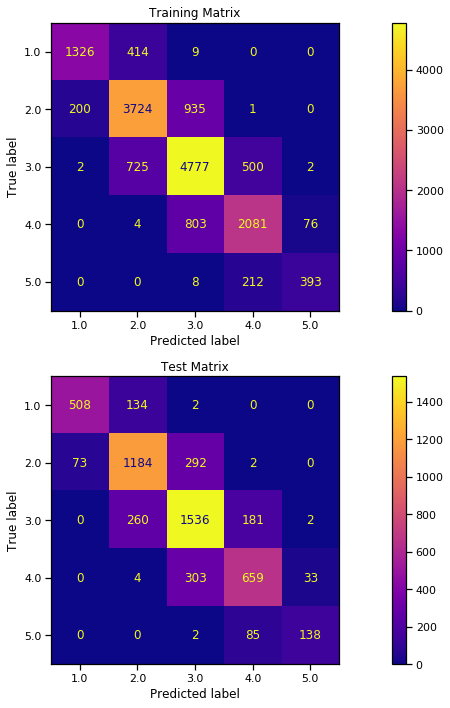

In [99]:
return_conf_matrix(scaled_pipeline_gbt, X_train, y_train, X_test, y_test)

Gradient Boosted Tree Classifier performs similarly on the training and test data, with a fair accuracy of 75%. The model however still struggles to predict some of the higher classes (level 4 and 5 burnout) and is not conservative enough when predicting the highest level of burnout (ie the model predicts that the employee has a burnout level of 4 when in reality they have a burnout level of 5), as evidenced by the lower recall score of 61% for level 5 in the test data.

##### Adaboost

The second gradient boosting algorithm that we will try is Adaboost. The algorithm works by training a single weak learner (tree) on a subset of data (bag), then identifying the samples the weak learner got wrong. The algorithm increases the weight of samples that the learners misclassify, thereby increasing the likelihood these hard samples will be sampled into the bag to train the next learner. As the iterations continue, there will be more hard samples in the bag to train the weak learners on, thus increasing the likelihood the learner will create an effective split to classify the hard example. 

In [100]:
from sklearn.ensemble import AdaBoostClassifier

In [101]:
scaled_pipeline_ab = Pipeline([("ss", StandardScaler()),
                             ("ab", AdaBoostClassifier(random_state=rand))])

In [102]:
ab_tr1, ab_ts1 = fit_return_metrics(scaled_pipeline_ab, X_train, y_train, X_test, y_test)

Training Metrics: 
              precision  recall  f1-score   support
1.0                0.00    0.00      0.00   1749.00
2.0                0.61    0.79      0.68   4860.00
3.0                0.72    0.69      0.70   6006.00
4.0                0.56    0.49      0.52   2964.00
5.0                0.36    0.94      0.53    613.00
accuracy           0.62    0.62      0.62      0.62
macro avg          0.45    0.58      0.49  16192.00
weighted avg       0.57    0.62      0.58  16192.00

Test Metrics: 
              precision  recall  f1-score  support
1.0                0.00    0.00      0.00    644.0
2.0                0.58    0.79      0.67   1551.0
3.0                0.72    0.68      0.70   1979.0
4.0                0.55    0.47      0.50    999.0
5.0                0.38    0.93      0.54    225.0
accuracy           0.60    0.60      0.60      0.6
macro avg          0.44    0.57      0.48   5398.0
weighted avg       0.55    0.60      0.56   5398.0


C:\Users\swzoe\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\swzoe\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\swzoe\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\s

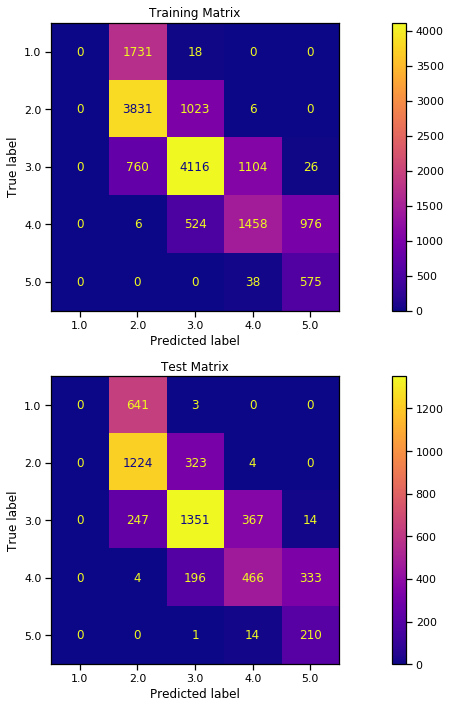

In [103]:
return_conf_matrix(scaled_pipeline_ab, X_train, y_train, X_test, y_test)

The AdaBoost Classifier has one of the lower accuracys compared to the other models, and made no predictions for class 1.

##### XG Boost

XGBoost is another implementation of gradient boosted trees, but optimized for speed and performance. 

In [104]:
from xgboost import XGBClassifier

In [105]:
scaled_pipeline_xg = Pipeline([("ss", StandardScaler()),
                             ("xg", XGBClassifier(random_state=rand))])

In [106]:
xg_tr1, xg_ts1 = fit_return_metrics(scaled_pipeline_xg, X_train, y_train, X_test, y_test)

Training Metrics: 
              precision  recall  f1-score   support
1.0                0.88    0.70      0.78   1749.00
2.0                0.75    0.76      0.76   4860.00
3.0                0.72    0.80      0.76   6006.00
4.0                0.74    0.67      0.71   2964.00
5.0                0.84    0.59      0.69    613.00
accuracy           0.75    0.75      0.75      0.75
macro avg          0.79    0.71      0.74  16192.00
weighted avg       0.75    0.75      0.75  16192.00

Test Metrics: 
              precision  recall  f1-score  support
1.0                0.91    0.76      0.83   644.00
2.0                0.75    0.78      0.76  1551.00
3.0                0.71    0.79      0.75  1979.00
4.0                0.72    0.64      0.68   999.00
5.0                0.82    0.59      0.69   225.00
accuracy           0.75    0.75      0.75     0.75
macro avg          0.78    0.71      0.74  5398.00
weighted avg       0.75    0.75      0.75  5398.00


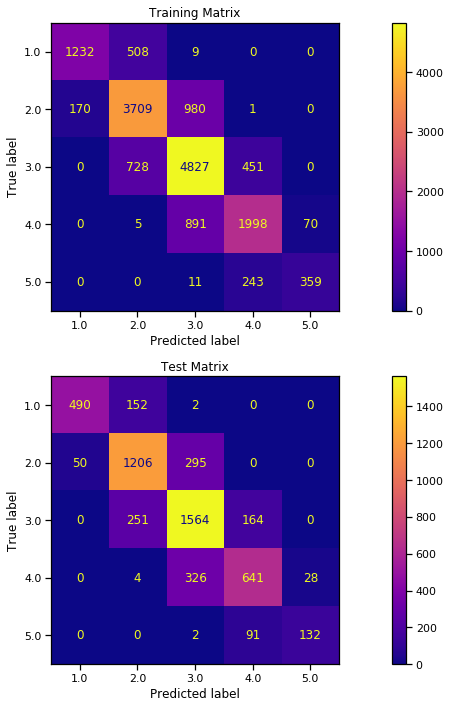

In [107]:
return_conf_matrix(scaled_pipeline_xg, X_train, y_train, X_test, y_test)

The model performs similarly on the training and testing data, with a fair accuracy of 75%. However, similar to some of the other models, the model is less discerning between the higher classes, and has poor recall for class 4 and 5, meaning the model is not as conservative as it should be in the higher classes (Out of all the actual level 5 burnout employees, the model only classified 59% correctly).

##### Support Vector Machines (SVM)

This algorithm seeks to find the separation line (plane in higher dimensions) that maximizes the distance between classes. For boundaries that cannot be represented linearly, a kernel is used. a kernel creates nonlinear combinations of original features and projects them onto a higher dimensional space, where classes can then be separated. 

In [108]:
from sklearn.svm import SVC

In [109]:
scaled_pipeline_svm = Pipeline([("ss", StandardScaler()),
                             ("sv", SVC(kernel="rbf", random_state=rand))])

In [110]:
sv_tr1, sv_ts1 = fit_return_metrics(scaled_pipeline_svm, X_train, y_train, X_test, y_test)

Training Metrics: 
              precision  recall  f1-score   support
1.0                0.87    0.73      0.79   1749.00
2.0                0.76    0.77      0.76   4860.00
3.0                0.73    0.79      0.76   6006.00
4.0                0.72    0.69      0.71   2964.00
5.0                0.84    0.54      0.66    613.00
accuracy           0.75    0.75      0.75      0.75
macro avg          0.78    0.70      0.74  16192.00
weighted avg       0.75    0.75      0.75  16192.00

Test Metrics: 
              precision  recall  f1-score  support
1.0                0.90    0.76      0.82   644.00
2.0                0.75    0.78      0.76  1551.00
3.0                0.72    0.77      0.75  1979.00
4.0                0.69    0.66      0.68   999.00
5.0                0.81    0.54      0.65   225.00
accuracy           0.74    0.74      0.74     0.74
macro avg          0.77    0.70      0.73  5398.00
weighted avg       0.75    0.74      0.74  5398.00


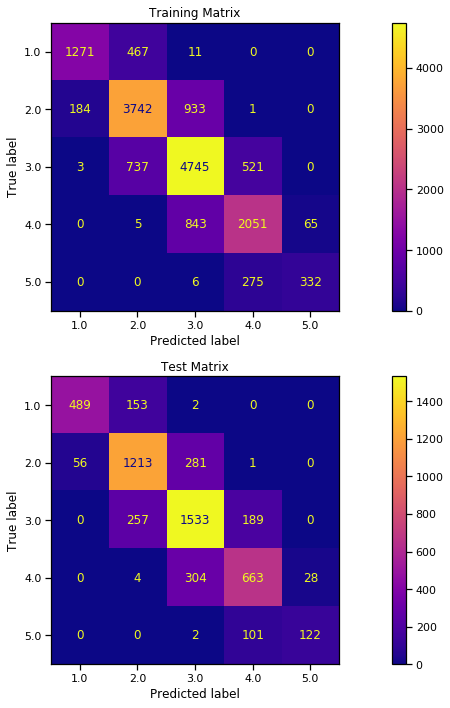

In [111]:
return_conf_matrix(scaled_pipeline_svm, X_train, y_train, X_test, y_test)

Base SVM model performs fairly well, but still lacks in recall for the higher classes (Out of all the actual level 5 burnout employees, the model only classified 54% correctly).

#### Advanced Models with Gridsearch

We will now perform the next modeling iteration, choosing the best baseline models to tune in order to achieve better results. The models we will tune are:

- KNN
- Random Forest
- Gradient Boosted Trees
- XG boost

We will focus on adjusting model hyperparameters and transforming the data to rectify class imbalances (through SMOTE).

##### KNN

In [112]:
from sklearn.model_selection import GridSearchCV
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline 

In [113]:
grid_knn = {'knn__weights': ["uniform", "distance"], 
         'knn__n_neighbors': [5, 30, 60, 90, 120]}

In [114]:
gridsearch_knn = GridSearchCV(estimator=scaled_pipeline_knn, param_grid = grid_knn, scoring="accuracy", cv=5)

In [115]:
gridsearch_knn.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [5, 30, 60, 90, 120],
                         'knn__weights': ['uniform', 'distance']},
             scoring='accuracy')

In [116]:
k, weight = gridsearch_knn.best_params_.values()

In [117]:
gridsearch_knn.best_params_

{'knn__n_neighbors': 30, 'knn__weights': 'uniform'}

In [118]:
grid_pipeline_knn = Pipeline([('ss', StandardScaler()),
                               ('kn', KNeighborsClassifier(n_neighbors=k, weights=weight))])

In [119]:
kn_tr2, kn_ts2 = fit_return_metrics(grid_pipeline_knn, X_train, y_train, X_test, y_test)

Training Metrics: 
              precision  recall  f1-score   support
1.0                0.87    0.70      0.77   1749.00
2.0                0.74    0.78      0.76   4860.00
3.0                0.72    0.80      0.76   6006.00
4.0                0.70    0.66      0.68   2964.00
5.0                0.86    0.33      0.48    613.00
accuracy           0.74    0.74      0.74      0.74
macro avg          0.78    0.65      0.69  16192.00
weighted avg       0.74    0.74      0.74  16192.00

Test Metrics: 
              precision  recall  f1-score  support
1.0                0.89    0.70      0.79   644.00
2.0                0.71    0.78      0.74  1551.00
3.0                0.70    0.76      0.73  1979.00
4.0                0.65    0.62      0.64   999.00
5.0                0.81    0.30      0.44   225.00
accuracy           0.71    0.71      0.71     0.71
macro avg          0.75    0.63      0.67  5398.00
weighted avg       0.72    0.71      0.71  5398.00


The model has a fair accuracy, but still lacks in terms of recall for the higher classes.

In [120]:
grid_knn2 = {'knn__n_neighbors': [29, 30, 32, 35, 37, 39]}

In [121]:
gridsearch_knn = GridSearchCV(estimator=scaled_pipeline_knn, param_grid = grid_knn2, scoring="accuracy", cv=5)

In [122]:
gridsearch_knn.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [29, 30, 32, 35, 37, 39]},
             scoring='accuracy')

In [123]:
k = gridsearch_knn.best_params_["knn__n_neighbors"]

In [124]:
grid_pipeline_knn2 = Pipeline([('ss', StandardScaler()),
                               ('kn', KNeighborsClassifier(n_neighbors=k, weights=weight))])

In [125]:
kn_tr3, kn_ts3 = fit_return_metrics(grid_pipeline_knn2, X_train, y_train, X_test, y_test)

Training Metrics: 
              precision  recall  f1-score   support
1.0                0.87    0.69      0.77   1749.00
2.0                0.74    0.78      0.76   4860.00
3.0                0.72    0.79      0.75   6006.00
4.0                0.70    0.66      0.68   2964.00
5.0                0.86    0.32      0.46    613.00
accuracy           0.74    0.74      0.74      0.74
macro avg          0.78    0.65      0.69  16192.00
weighted avg       0.74    0.74      0.73  16192.00

Test Metrics: 
              precision  recall  f1-score  support
1.0                0.89    0.70      0.79   644.00
2.0                0.71    0.78      0.74  1551.00
3.0                0.70    0.76      0.73  1979.00
4.0                0.66    0.63      0.64   999.00
5.0                0.82    0.30      0.44   225.00
accuracy           0.72    0.72      0.72     0.72
macro avg          0.76    0.63      0.67  5398.00
weighted avg       0.72    0.72      0.71  5398.00


The model still lacks in recall for the higher classes. We will try smoting the data to account for class imbalance.

In [126]:
smote_pipeline_knn = Pipeline([('ss', StandardScaler()),
                               ('sm', SMOTE(random_state=rand)),
                               ('kn', KNeighborsClassifier(n_neighbors=k, weights=weight))])

In [127]:
kn_tr4, kn_ts4 = fit_return_metrics(smote_pipeline_knn, X_train, y_train, X_test, y_test)

Training Metrics: 
              precision  recall  f1-score   support
1.0                0.70    0.89      0.78   1749.00
2.0                0.74    0.72      0.73   4860.00
3.0                0.77    0.64      0.70   6006.00
4.0                0.64    0.69      0.66   2964.00
5.0                0.52    0.91      0.67    613.00
accuracy           0.71    0.71      0.71      0.71
macro avg          0.67    0.77      0.71  16192.00
weighted avg       0.72    0.71      0.71  16192.00

Test Metrics: 
              precision  recall  f1-score  support
1.0                0.73    0.89      0.80   644.00
2.0                0.71    0.73      0.72  1551.00
3.0                0.75    0.62      0.68  1979.00
4.0                0.61    0.63      0.62   999.00
5.0                0.50    0.83      0.62   225.00
accuracy           0.69    0.69      0.69     0.69
macro avg          0.66    0.74      0.69  5398.00
weighted avg       0.70    0.69      0.69  5398.00


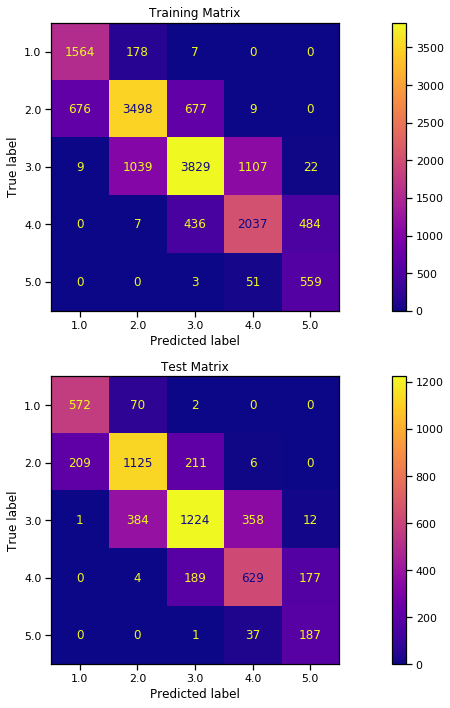

In [128]:
return_conf_matrix(smote_pipeline_knn, X_train, y_train, X_test, y_test)

While the models accuracy decreased, the recall for the higher classes increased, likely due to using SMOTE to rectify the class imbalance.

##### Random Forest

In [129]:
grid_rf = {"rf__criterion": ["gini", "entropy"],
            "rf__n_estimators": [10, 30, 100],
            "rf__max_depth": [2, 6, 10],
            "rf__min_samples_split": [2, 5, 10],
            "rf__min_samples_leaf": [1, 3, 6],
                }

In [130]:
gridsearch_rf = GridSearchCV(estimator=scaled_pipeline_rf, param_grid = grid_rf, scoring="accuracy", cv=5)

In [131]:
gridsearch_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('rf',
                                        RandomForestClassifier(random_state=1))]),
             param_grid={'rf__criterion': ['gini', 'entropy'],
                         'rf__max_depth': [2, 6, 10],
                         'rf__min_samples_leaf': [1, 3, 6],
                         'rf__min_samples_split': [2, 5, 10],
                         'rf__n_estimators': [10, 30, 100]},
             scoring='accuracy')

In [132]:
crit, max_dep, min_leaf, min_split, n_est = gridsearch_rf.best_params_.values()

In [133]:
grid_pipeline_rf = Pipeline([('ss', StandardScaler()),
                            ('rf', RandomForestClassifier(random_state=rand,criterion=crit, max_depth=max_dep, min_samples_leaf=min_leaf, min_samples_split=min_split, n_estimators=n_est))])

In [134]:
rf_tr2, rf_ts2 = fit_return_metrics(grid_pipeline_rf, X_train, y_train, X_test, y_test)

Training Metrics: 
              precision  recall  f1-score   support
1.0                0.91    0.76      0.83   1749.00
2.0                0.78    0.79      0.79   4860.00
3.0                0.75    0.83      0.78   6006.00
4.0                0.77    0.72      0.75   2964.00
5.0                0.92    0.62      0.74    613.00
accuracy           0.78    0.78      0.78      0.78
macro avg          0.83    0.74      0.78  16192.00
weighted avg       0.79    0.78      0.78  16192.00

Test Metrics: 
              precision  recall  f1-score  support
1.0                0.91    0.76      0.83   644.00
2.0                0.74    0.77      0.76  1551.00
3.0                0.71    0.78      0.74  1979.00
4.0                0.70    0.65      0.68   999.00
5.0                0.84    0.59      0.69   225.00
accuracy           0.74    0.74      0.74     0.74
macro avg          0.78    0.71      0.74  5398.00
weighted avg       0.75    0.74      0.74  5398.00


This new model suffers from less overfitting and has better accuracy on the test data. However, the model still has low recall for the higher classes.

We will try Smoting the data to account for class imbalance (since class 5 makes up only 3% of the class labels).

In [135]:
smote_pipeline_rf = Pipeline([('ss', StandardScaler()),
                             ('sm', SMOTE(random_state=rand)),
                            ('rf', RandomForestClassifier(random_state=rand, criterion=crit, max_depth=max_dep, min_samples_leaf=min_leaf, min_samples_split=min_split, n_estimators=n_est))])

In [136]:
rf_tr3, rf_ts3 = fit_return_metrics(smote_pipeline_rf, X_train, y_train, X_test, y_test)

Training Metrics: 
              precision  recall  f1-score   support
1.0                0.79    0.87      0.83   1749.00
2.0                0.78    0.77      0.78   4860.00
3.0                0.79    0.69      0.74   6006.00
4.0                0.68    0.76      0.72   2964.00
5.0                0.62    0.85      0.72    613.00
accuracy           0.76    0.76      0.76      0.76
macro avg          0.73    0.79      0.76  16192.00
weighted avg       0.76    0.76      0.76  16192.00

Test Metrics: 
              precision  recall  f1-score  support
1.0                0.79    0.87      0.83   644.00
2.0                0.73    0.75      0.74  1551.00
3.0                0.75    0.65      0.70  1979.00
4.0                0.64    0.67      0.66   999.00
5.0                0.58    0.83      0.68   225.00
accuracy           0.72    0.72      0.72     0.72
macro avg          0.70    0.76      0.72  5398.00
weighted avg       0.72    0.72      0.72  5398.00


The smoting decreased the model's accuracy slightly, but seems to have improved recall for class 5, signifying that this model is more conservative when predicting the highest burnout level (ie more instances of predicting 5, when in reality the employee had level 4).

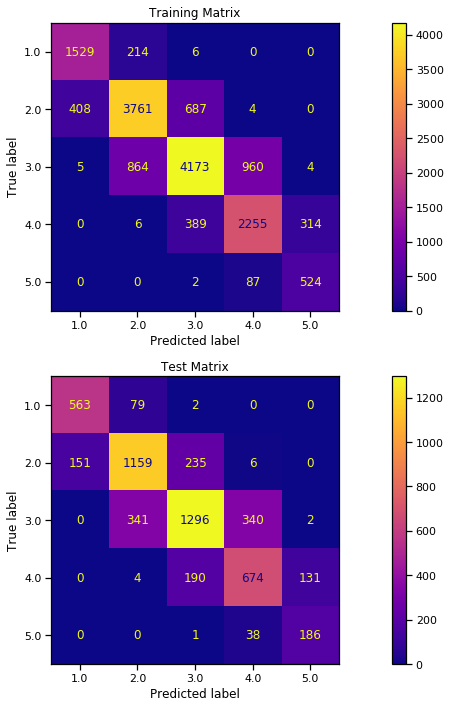

In [137]:
return_conf_matrix(smote_pipeline_rf, X_train, y_train, X_test, y_test)

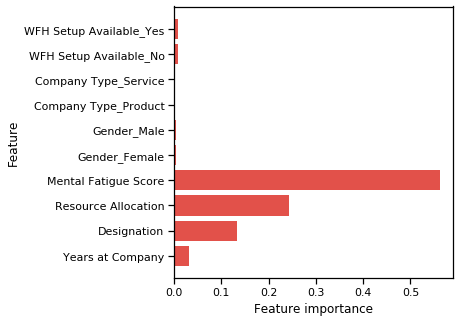

In [138]:
plot_feature_importances(smote_pipeline_rf.steps[2][1])

##### Gradient Boosted Trees

In [139]:
grid_gbt = {
            "gb__max_depth": [5, 6],
            "gb__min_samples_split": [2, 10]
                }

In [140]:
gridsearch_gbt = GridSearchCV(estimator=scaled_pipeline_gbt, param_grid = grid_gbt, scoring="accuracy", cv=5)

In [141]:
gridsearch_gbt.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('gb',
                                        GradientBoostingClassifier(random_state=1))]),
             param_grid={'gb__max_depth': [5, 6],
                         'gb__min_samples_split': [2, 10]},
             scoring='accuracy')

In [142]:
gb_max_dep, gb_split = gridsearch_gbt.best_params_.values()

In [143]:
grid_pipeline_gbt = Pipeline(steps=[('ss', StandardScaler()),
                ('gb', GradientBoostingClassifier(random_state=rand, max_depth=gb_max_dep, min_samples_split=gb_split))])

In [144]:
gbt_tr2, gbt_ts2 = fit_return_metrics(grid_pipeline_gbt, X_train, y_train, X_test, y_test)

Training Metrics: 
              precision  recall  f1-score   support
1.0                0.91    0.80      0.85   1749.00
2.0                0.79    0.80      0.79   4860.00
3.0                0.75    0.82      0.79   6006.00
4.0                0.79    0.73      0.76   2964.00
5.0                0.94    0.75      0.83    613.00
accuracy           0.79    0.79      0.79      0.79
macro avg          0.84    0.78      0.81  16192.00
weighted avg       0.80    0.79      0.79  16192.00

Test Metrics: 
              precision  recall  f1-score  support
1.0                0.86    0.77      0.81   644.00
2.0                0.74    0.75      0.74  1551.00
3.0                0.71    0.77      0.74  1979.00
4.0                0.70    0.65      0.68   999.00
5.0                0.77    0.58      0.66   225.00
accuracy           0.74    0.74      0.74     0.74
macro avg          0.76    0.71      0.73  5398.00
weighted avg       0.74    0.74      0.74  5398.00


Similar to the other models, the model has an accuracy around 74%, but still shows poor recall for the higher classes. We will SMOTE the dataset to help with class imbalance for the higher classes.

In [145]:
smote_pipeline_gbt = Pipeline(steps=[('ss', StandardScaler()),
                                     ('sm', SMOTE(random_state=rand)),
                                    ('gb', GradientBoostingClassifier(random_state=rand, max_depth=gb_max_dep, min_samples_split=gb_split))])

In [146]:
gbt_tr3, gbt_ts3 = fit_return_metrics(smote_pipeline_gbt, X_train, y_train, X_test, y_test)

Training Metrics: 
              precision  recall  f1-score   support
1.0                0.83    0.84      0.84   1749.00
2.0                0.78    0.78      0.78   4860.00
3.0                0.78    0.74      0.76   6006.00
4.0                0.71    0.75      0.73   2964.00
5.0                0.73    0.79      0.76    613.00
accuracy           0.77    0.77      0.77      0.77
macro avg          0.76    0.78      0.77  16192.00
weighted avg       0.77    0.77      0.77  16192.00

Test Metrics: 
              precision  recall  f1-score  support
1.0                0.81    0.84      0.83   644.00
2.0                0.73    0.75      0.74  1551.00
3.0                0.74    0.69      0.72  1979.00
4.0                0.66    0.68      0.67   999.00
5.0                0.64    0.72      0.68   225.00
accuracy           0.73    0.73      0.73     0.73
macro avg          0.72    0.74      0.73  5398.00
weighted avg       0.73    0.73      0.73  5398.00


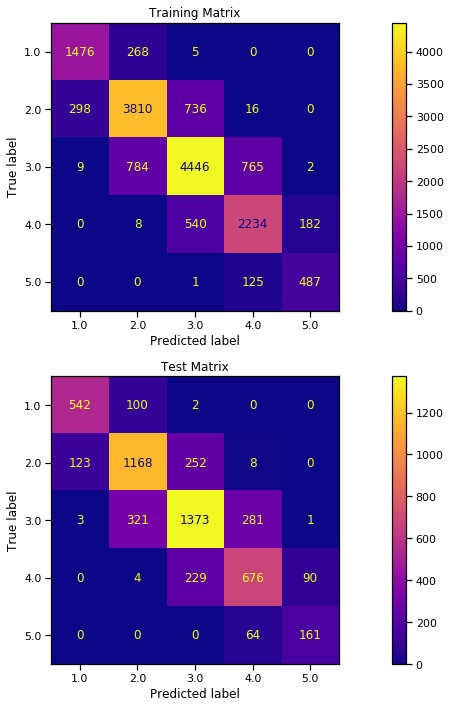

In [147]:
return_conf_matrix(smote_pipeline_gbt, X_train, y_train, X_test, y_test)

The new gradient boosted model, with smoting and parameter adjustments gives a fair accuracy of around 73%. The recall scores for levels 4 and 5 have improved.

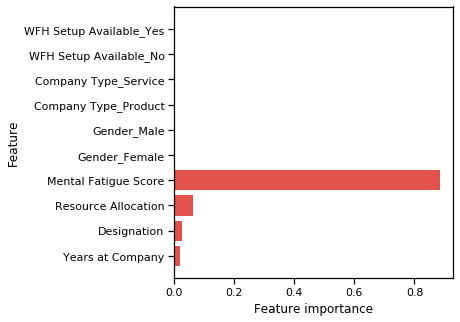

In [148]:
plot_feature_importances(smote_pipeline_gbt.steps[2][1])

##### XG Boost

In [149]:
grid_xgb = {
            "xg__max_depth": [3, 5, 6],
            "xg__n_estimators": [30, 50, 100]
                }

In [150]:
gridsearch_xgb = GridSearchCV(estimator=scaled_pipeline_xg, param_grid = grid_xgb, scoring="accuracy", cv=5)

In [151]:
gridsearch_xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('xg',
                                        XGBClassifier(objective='multi:softprob',
                                                      random_state=1))]),
             param_grid={'xg__max_depth': [3, 5, 6],
                         'xg__n_estimators': [30, 50, 100]},
             scoring='accuracy')

In [152]:
xg_dep, xg_nest = gridsearch_xgb.best_params_.values()

In [153]:
grid_pipeline_xg = Pipeline([("ss", StandardScaler()),
                             ("xg", XGBClassifier(random_state=rand, max_depth=xg_dep, n_estimators=xg_nest))])

In [154]:
xg_tr2, xg_ts2 = fit_return_metrics(grid_pipeline_xg, X_train, y_train, X_test, y_test)

Training Metrics: 
              precision  recall  f1-score   support
1.0                0.88    0.73      0.80   1749.00
2.0                0.76    0.76      0.76   4860.00
3.0                0.72    0.80      0.76   6006.00
4.0                0.74    0.67      0.71   2964.00
5.0                0.84    0.60      0.70    613.00
accuracy           0.75    0.75      0.75      0.75
macro avg          0.79    0.72      0.74  16192.00
weighted avg       0.76    0.75      0.75  16192.00

Test Metrics: 
              precision  recall  f1-score  support
1.0                0.90    0.77      0.83   644.00
2.0                0.75    0.77      0.76  1551.00
3.0                0.72    0.79      0.75  1979.00
4.0                0.72    0.65      0.68   999.00
5.0                0.81    0.60      0.69   225.00
accuracy           0.75    0.75      0.75     0.75
macro avg          0.78    0.72      0.74  5398.00
weighted avg       0.75    0.75      0.75  5398.00


In [155]:
smote_pipeline_xg = Pipeline([("ss", StandardScaler()),
                              ("sm", SMOTE(random_state=rand)),
                             ("xg", XGBClassifier(random_state=rand, max_depth=xg_dep, n_estimators=xg_nest))])

In [156]:
xg_tr3, xg_ts3 = fit_return_metrics(smote_pipeline_xg, X_train, y_train, X_test, y_test)

Training Metrics: 
              precision  recall  f1-score   support
1.0                0.74    0.86      0.80   1749.00
2.0                0.76    0.73      0.74   4860.00
3.0                0.76    0.68      0.72   6006.00
4.0                0.66    0.71      0.68   2964.00
5.0                0.57    0.82      0.67    613.00
accuracy           0.73    0.73      0.73      0.73
macro avg          0.70    0.76      0.72  16192.00
weighted avg       0.73    0.73      0.73  16192.00

Test Metrics: 
              precision  recall  f1-score  support
1.0                0.78    0.88      0.83   644.00
2.0                0.74    0.75      0.75  1551.00
3.0                0.76    0.67      0.71  1979.00
4.0                0.65    0.67      0.66   999.00
5.0                0.59    0.85      0.69   225.00
accuracy           0.73    0.73      0.73     0.73
macro avg          0.70    0.76      0.73  5398.00
weighted avg       0.73    0.73      0.73  5398.00


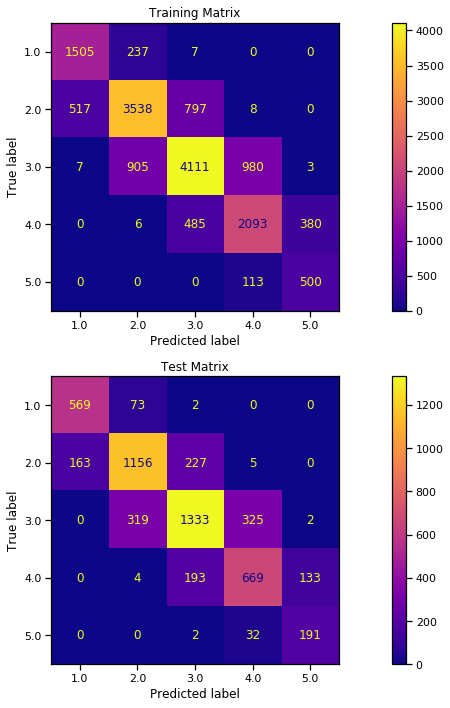

In [157]:
return_conf_matrix(smote_pipeline_xg, X_train, y_train, X_test, y_test)

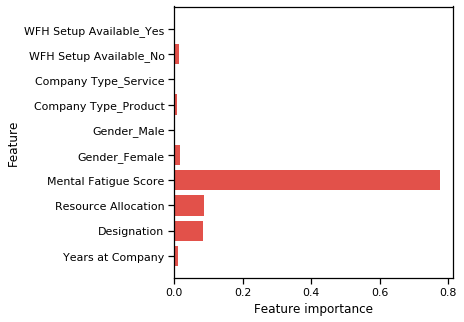

In [158]:
plot_feature_importances(smote_pipeline_xg.steps[2][1])

XGBoost model also improved significantly for recall for class 5 with smoting of data and still has fair accuracy around 73%.

### Final Model and Conclusions

In [170]:
xgrf_table = pd.concat([xg_ts3, rf_ts3], axis=1, keys=["XGBoost", "Random Forest"])
xgrf_table

XGBoost                          Random Forest                  \
             precision recall f1-score  support     precision recall f1-score   
1.0               0.78   0.88     0.83   644.00          0.79   0.87     0.83   
2.0               0.74   0.75     0.75  1551.00          0.73   0.75     0.74   
3.0               0.76   0.67     0.71  1979.00          0.75   0.65     0.70   
4.0               0.65   0.67     0.66   999.00          0.64   0.67     0.66   
5.0               0.59   0.85     0.69   225.00          0.58   0.83     0.68   
accuracy          0.73   0.73     0.73     0.73          0.72   0.72     0.72   
macro avg         0.70   0.76     0.73  5398.00          0.70   0.76     0.72   
weighted avg      0.73   0.73     0.73  5398.00          0.72   0.72     0.72   

                       
              support  
1.0            644.00  
2.0           1551.00  
3.0           1979.00  
4.0            999.00  
5.0            225.00  
accuracy         0.72  
macro avg     5398.00  
weighted avg  5398.00

The top performing models were XGBoost and Random Forest. While most models performed similarly in accuracy for the test datasets, XGBoost and Random Forest had higher recall for the the top class (Burnout Level 5). Considering that in this case we'd prefer a more conservative model (ie decrease the possibility of missing a class 5 burnout (False Negative)), the preferred model is XGBoost with a recall of 85% for class 5 and an overall accuracy of 73%.

In [171]:
xgb_compare = pd.concat([xg_ts1, xg_ts3], axis=1, keys=["XGBoost Base", "XGBoost Tuned"])

In [172]:
xgb_compare

XGBoost Base                          XGBoost Tuned         \
                precision recall f1-score  support     precision recall   
1.0                  0.91   0.76     0.83   644.00          0.78   0.88   
2.0                  0.75   0.78     0.76  1551.00          0.74   0.75   
3.0                  0.71   0.79     0.75  1979.00          0.76   0.67   
4.0                  0.72   0.64     0.68   999.00          0.65   0.67   
5.0                  0.82   0.59     0.69   225.00          0.59   0.85   
accuracy             0.75   0.75     0.75     0.75          0.73   0.73   
macro avg            0.78   0.71     0.74  5398.00          0.70   0.76   
weighted avg         0.75   0.75     0.75  5398.00          0.73   0.73   

                                
             f1-score  support  
1.0              0.83   644.00  
2.0              0.75  1551.00  
3.0              0.71  1979.00  
4.0              0.66   999.00  
5.0              0.69   225.00  
accuracy         0.73     0.73  
macro avg        0.73  5398.00  
weighted avg     0.73  5398.00

Some important metrics:

- 73% accuracy (73% of all the predictions for level of burnout were correctly classified)
- 73% overall precision (On average, out of all the times the model predicted a burnout of X level, 73% actually had that level of burnout)
- 85% recall for class 5 (Out of all the actual level 5 burnout employees, the model correctly predicted 85% of them)
- F1 score of 73% overall, shows balance between precision and recall

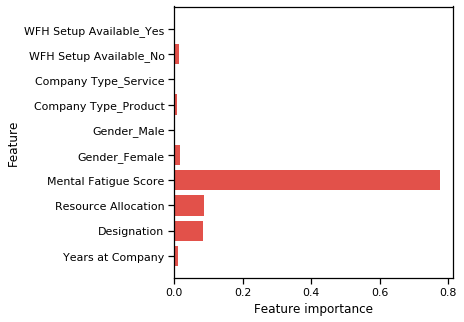

In [173]:
plot_feature_importances(smote_pipeline_xg.steps[2][1])

The top three most important features for this model were:

- Mental Fatigue Score
- Resource Allocation
- Designation

In [174]:
final_model = smote_pipeline_xg.fit(X_train, y_train)

### Predictions

In [175]:
data_pre, ids = preprocess(data_test)

In [176]:
predict(final_model, data_pre, ids)

,Employee ID,Burnout Level (Preds)
0,fffe31003300390039003000,4.0
1,fffe31003300310037003800,2.0
2,fffe33003400380035003900,3.0
3,fffe3100370039003200,2.0
4,fffe32003600390036003700,3.0
...,...,...
12245,fffe3900310034003700,3.0
12246,fffe32003600330034003000,3.0
12247,fffe31003800340039003000,5.0
12248,fffe32003600380031003800,3.0
